In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [21]:
class Network(object):

    def __init__(self, sizes, func_model):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.activate_func = func_model["activate_func"]
        self.activate_func_prime = func_model["activate_func_prime"]
        self.cost_func = func_model["cost_func"]
        self.cost_derivative = func_model["cost_derivative"]

    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.activate_func(np.dot(w, a) + b)
        return a


    def SGD(self, training_data, epochs, mini_batch_size, eta, 
            test_data=None,
            plot=False,
            lmbda=0.0):
        training_data = list(training_data)
        n = len(training_data)
        epoch_eval=[]
        
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)
        
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k + mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
            if test_data:
                error=self.evaluate(test_data)

                if plot:
                    epoch_eval.append(error)
                print("Epoch {} Cost: {}".format(
                    j, error))
            else:
                print("Epoch {} complete".format(j))
        if plot:
            plt.plot(epoch_eval)
            plt.show()

    def evaluate(self,test_data):
        def std(a,y):
            return np.sqrt((a-y)**2)
        return np.array([std(self.feedforward(item[0]),item[1]) for item in test_data]).mean()


    def update_mini_batch(self, mini_batch, eta, lmbda, n):

#         nabla_b = [np.zeros(b.shape) for b in self.biases]
#         nabla_w = [np.zeros(w.shape) for w in self.weights]
#         for x, y in mini_batch:
#             delta_nabla_b, delta_nabla_w = self.backprop(x, y)
#             nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
#             nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
#         self.weights = [w - (eta / len(mini_batch)) * nw
#                         for w, nw in zip(self.weights, nabla_w)]
#         self.biases = [b - (eta / len(mini_batch)) * nb
#                        for b, nb in zip(self.biases, nabla_b)]

        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = self.activate_func(z)
            activations.append(activation)
        delta = self.cost_derivative(activations[-1], y) * \
            self.activate_func_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())

        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = self.activate_func_prime(z)
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

In [3]:
data=pd.read_excel('training_data.xlsx')

In [4]:
print(data.columns)

Index(['buffer', 'RTT', 'avg_speed', 'buffer_delay', 'stuck_ratio'], dtype='object')


In [5]:
data.describe()

,buffer,RTT,avg_speed,buffer_delay,stuck_ratio
count,74136.000000,74136.000000,74136.00000,74136.000000,74136.000000
mean,40644.076751,51.597119,5739.62902,1440.801932,0.056414
std,22525.913360,21.781843,968.04202,1383.820098,0.790739
min,304.000000,15.000000,10.00000,510.000000,0.000000
25%,22718.000000,36.000000,5644.00000,855.000000,0.000000
50%,37189.500000,47.000000,5918.00000,1094.000000,0.000000
75%,55428.250000,61.000000,6147.00000,1557.000000,0.000000
max,159225.000000,149.000000,29332.00000,30552.000000,44.667000


In [6]:
data.corr() #可以看到各变量几乎相互独立

,buffer,RTT,avg_speed,buffer_delay,stuck_ratio
buffer,1.000000,-0.199061,0.244814,-0.456585,-0.107332
RTT,-0.199061,1.000000,-0.053021,0.383575,0.043119
avg_speed,0.244814,-0.053021,1.000000,-0.490241,-0.331971
buffer_delay,-0.456585,0.383575,-0.490241,1.000000,0.279724
stuck_ratio,-0.107332,0.043119,-0.331971,0.279724,1.000000


In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))


def cost_derivative(a, y):
    # return (output_activations-y)
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

def cost_func(a, y):
    # return 0.5 * np.linalg.norm(output_activations - y)
    return (a-y)

func_model = {"activate_func": sigmoid,
              "activate_func_prime": sigmoid_prime,
              "cost_func": cost_func,
              "cost_derivative": cost_derivative, }

In [8]:
training_data=data[data['stuck_ratio']!=0]
training_data.head()

,buffer,RTT,avg_speed,buffer_delay,stuck_ratio
138,10575,36,1643,4665,1.355
206,40323,73,5844,2817,0.025
249,22609,27,6792,5990,0.170
262,22648,94,3105,1879,0.299
501,7462,58,6262,3193,0.029


In [9]:
def unify(series):
    return (series-series.min())/(series.max()-series.min())

In [10]:
for i in training_data:
    training_data[i]=unify(training_data[i])

C:\Users\84338\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
training_data.head()

,buffer,RTT,avg_speed,buffer_delay,stuck_ratio
138,0.098041,0.145038,0.055692,0.135804,0.030314
206,0.381999,0.427481,0.198963,0.074111,0.000537
249,0.212911,0.076336,0.231294,0.180037,0.003784
262,0.213283,0.587786,0.105552,0.042798,0.006672
501,0.068326,0.312977,0.213219,0.086663,0.000627


In [12]:
inputs=np.vstack([training_data["buffer"].values,training_data["RTT"].values,training_data["avg_speed"].values]).transpose()

inputs=np.hsplit(inputs.transpose(),inputs[:,0].size)

outputs=np.vstack([training_data["buffer_delay"].values,training_data["stuck_ratio"].values]).transpose()

outputs=np.hsplit(outputs.transpose(),outputs[:,0].size)

In [13]:
_train=list(zip(inputs,outputs))
type(_train[0][1])
_train[0]

(array([[ 0.09804127],
        [ 0.14503817],
        [ 0.05569197]]), array([[ 0.13580371],
        [ 0.03031389]]))

In [14]:
len(_train)

4070

In [22]:
network = Network([3,6,2], func_model)

In [16]:
import datetime

In [17]:
datetime.datetime.now()

datetime.datetime(2017, 5, 23, 14, 45, 32, 474841)

Epoch 0 Cost: 0.32527661448445644
Epoch 1 Cost: 0.2875179689746371
Epoch 2 Cost: 0.25531675595981496
Epoch 3 Cost: 0.22800375586751473
Epoch 4 Cost: 0.20496401596893934
Epoch 5 Cost: 0.1856285751525224
Epoch 6 Cost: 0.16935589150338523
Epoch 7 Cost: 0.15554452193101123
Epoch 8 Cost: 0.14381185472969404
Epoch 9 Cost: 0.13385451802182352
Epoch 10 Cost: 0.12525310983492988
Epoch 11 Cost: 0.11790975044582394
Epoch 12 Cost: 0.11155838076189745
Epoch 13 Cost: 0.10599692066266285
Epoch 14 Cost: 0.1010773238453616
Epoch 15 Cost: 0.09678110538230056
Epoch 16 Cost: 0.09301854189278454
Epoch 17 Cost: 0.08973203486647471
Epoch 18 Cost: 0.08686512546060841
Epoch 19 Cost: 0.08433951784820425
Epoch 20 Cost: 0.08208544306876016
Epoch 21 Cost: 0.08010745232620149
Epoch 22 Cost: 0.07835531594443278
Epoch 23 Cost: 0.0768013953085125
Epoch 24 Cost: 0.07543425094605566
Epoch 25 Cost: 0.0742490566458289
Epoch 26 Cost: 0.07317156012293549
Epoch 27 Cost: 0.07220933095454433
Epoch 28 Cost: 0.07136357545567809


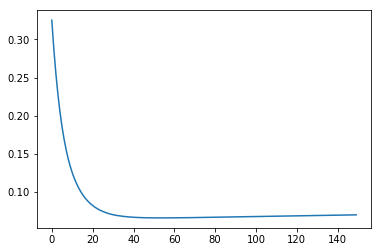

time_consume: 0:01:04.598858


In [23]:
_start =datetime.datetime.now()
network.SGD(_train[:3000],150,100,0.01,test_data=_train[3000:],lmbda=0.01,plot=True)
_end=datetime.datetime.now()
print("time_consume: {}".format(_end-_start))